#### A-Ci Kurve programmieren mit GerriKAI

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Daten laden
data = pd.read_csv("/Users/gerrik/Desktop/photosynthesis_data1.csv", sep=";")
data.head()

,Plant_ID,Ci,A_measured,A_modeled,Vcmax,J,Rd,TPU,gm
0,KD,"60,70156982","-3,172402228","-2,655739453",110,"165,5","7,122448951","12,01726535","0,839391745"
1,KD,"94,05001611","0,664819418","1,65487558",110,"165,5","7,122448951","12,01726535","0,839391745"
2,KD,"127,3087619","5,022311715","5,532979316",110,"165,5","7,122448951","12,01726535","0,839391745"
3,KD,"161,3604433","8,076659708","9,413076482",110,"165,5","7,122448951","12,01726535","0,839391745"
4,KD,"196,3258286","12,81083249","12,87234344",110,"165,5","7,122448951","12,01726535","0,839391745"


In [7]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer

def insert_rows_and_impute(data, group_col='Plant_ID', insert_factor=1, n_neighbors=1):
    """
    Für jede Gruppe (Plant_ID) werden zusätzliche Zwischenzeilen eingefügt.
    insert_factor=2 bedeutet, dass zwischen zwei Originalzeilen genau eine Zeile eingefügt wird.
    Anschließend wird der KNNImputer auf numerische Spalten angewendet.
    """
    groups = []
    
    # Gruppiere nach der gewünschten Spalte
    for plant, group in data.groupby(group_col):
        group = group.copy()
        # Setze den Index zurück, um eine kontinuierliche Sequenz zu erhalten
        group.index = np.arange(len(group))
        
        # Berechne einen neuen Index: Zwischen jedem Originalindex wird ein zusätzlicher Punkt eingefügt.
        new_index = np.linspace(group.index.min(), group.index.max(), num=(len(group)*insert_factor - (insert_factor-1)))
        group_extended = group.reindex(new_index)
        
        # Nicht-numerische Spalten (wie Plant_ID) mittels Vorwärts-/Rückwärtsfüllung auffüllen
        non_numeric_cols = group_extended.select_dtypes(exclude=[np.number]).columns
        group_extended[non_numeric_cols] = group_extended[non_numeric_cols].ffill().bfill()
        
        # Imputation: Wende den KNNImputer auf numerische Spalten an
        imputer = KNNImputer(n_neighbors=n_neighbors)
        numeric_cols = group_extended.select_dtypes(include=[np.number]).columns
        group_extended[numeric_cols] = imputer.fit_transform(group_extended[numeric_cols])
        
        # Füge die bearbeitete Gruppe der Liste hinzu
        groups.append(group_extended)
    
    # Füge alle Gruppen wieder zusammen und setze optional den Index zurück
    final_df = pd.concat(groups).reset_index(drop=True)
    return final_df

# Beispielanwendung:
data_imputed = insert_rows_and_impute(data, group_col="Plant_ID", insert_factor=1, n_neighbors=1)
print(data_imputed.head(30))



   Plant_ID           Ci  A_measured  A_modeled       Vcmax           J  \
0        KD    60.701570   -3.172402  -2.655739  110.000000  165.500000   
1        KD    94.050016    0.664819   1.654876  110.000000  165.500000   
2        KD   127.308762    5.022312   5.532979  110.000000  165.500000   
3        KD   161.360443    8.076660   9.413076  110.000000  165.500000   
4        KD   196.325829   12.810832  12.872343  110.000000  165.500000   
5        KD   228.623394   15.376807  16.075729  110.000000  165.500000   
6        KD   268.855992   19.837772  19.614541  110.000000  165.500000   
7        KD   294.944426   22.037570  20.839150  110.000000  165.500000   
8        KD   485.360764   28.201614  25.509018  110.000000  165.500000   
9        KD  1368.695686   28.929370  28.929347  110.000000  165.500000   
10       KN    52.720658   -1.100000  -0.952021   99.625248  136.855774   
11       KN    86.000437    3.000000   3.105803   99.625248  136.855774   
12       KN   121.182389 

In [5]:
cols = ["Ci", "A_measured", "A_modeled", "Vcmax", "J", "Rd", "TPU", "gm"]

for col in cols:
    data[col] = data[col].astype(str).str.replace(',', '.').astype(float)


**FvCB-Modell implementieren**

Ziel: Das Sharkey-Modell mit TPU und gm programmieren.

- Schritte:
- FvCB-Funktion definieren:
- Ergänzt den Code mit der Modellfunktion:

In [10]:
# Bedingungen
O2 = 21 * 1000 / 101  # µmol/mol
Gamma_star = 4.2      # µmol/mol
Kc = 40.4             # µmol/mol
Ko = 24800 / 101      # µmol/mol

# FvCB-Modell
def fvcb_model(Ci, Vcmax, J, Rd, TPU, gm, Gamma_star, Kc, Ko, O2):
    Ac = Vcmax * (Ci - Gamma_star) / (Ci + Kc * (1 + O2 / Ko)) - Rd
    Aj = J * (Ci - Gamma_star) / (4 * (Ci + 2 * Gamma_star)) - Rd
    At = 3 * TPU - Rd
    A = np.minimum(np.minimum(Ac, Aj), At)
    return np.maximum(A, 0)  # Keine negativen Werte

**Ci-Bereich für glatte Kurve**

In [11]:
Ci_range = np.linspace(0, 1000, 200)

In [12]:
Ci_range = np.array(Ci_range, dtype=float)


In [13]:
Gamma_star = pd.to_numeric(Gamma_star)
Kc = pd.to_numeric(Kc)
Ko = pd.to_numeric(Ko)
O2 = pd.to_numeric(O2)


In [14]:
data["Ci"] = pd.to_numeric(data["Ci"], errors="coerce")
data["A_measured"] = pd.to_numeric(data["A_measured"], errors="coerce")
data["A_modeled"] = pd.to_numeric(data["A_modeled"], errors="coerce")
# usw.


**Professionelle Visualisierung mit Seaborn**
Code für Plot

/var/folders/xs/6ky5v5rd4h7g1mmvcjg_4t4h0000gn/T/ipykernel_9568/845081728.py:35: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


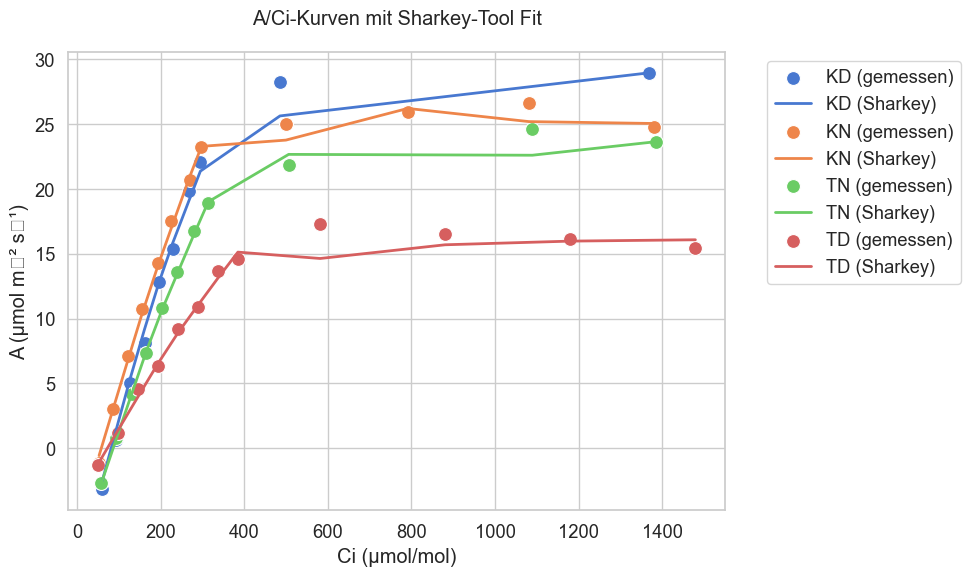

In [23]:
# Seaborn-Stil für professionelles Aussehen
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Plot erstellen
plt.figure(figsize=(10, 6))
plants = data["Plant_ID"].unique()

for plant in plants:
    plant_data = data[data["Plant_ID"] == plant]
    Vcmax = plant_data["Vcmax"].iloc[0]
    J = plant_data["J"].iloc[0]
    Rd = plant_data["Rd"].iloc[0]
    TPU = plant_data["TPU"].iloc[0]
    gm = plant_data["gm"].iloc[0]

    # Glatte Kurve
    # A_curve = fvcb_model(Ci_range, Vcmax, J, Rd, TPU, gm, Gamma_star, Kc, Ko, O2)
    # plt.plot(Ci_range, A_curve, label=f"{plant} (Kurve)", linewidth=2)

    # Gemessene Punkte
    sns.scatterplot(x="Ci", y="A_measured", data=plant_data, 
                    label=f"{plant} (gemessen)", marker="o", s=100)

    # Modellierte Punkte
    sns.regplot(x="Ci", y="A_modeled", data=plant_data,
            label=f"{plant} (Sharkey)", lowess=True, scatter=False,
            line_kws={'linewidth': 2})


# Achsen und Titel
plt.xlabel("Ci (µmol/mol)")
plt.ylabel("A (µmol m⁻² s⁻¹)")
plt.title("A/Ci-Kurven mit Sharkey-Tool Fit", pad=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Anzeigen
plt.show()

/var/folders/xs/6ky5v5rd4h7g1mmvcjg_4t4h0000gn/T/ipykernel_9568/3656119557.py:90: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


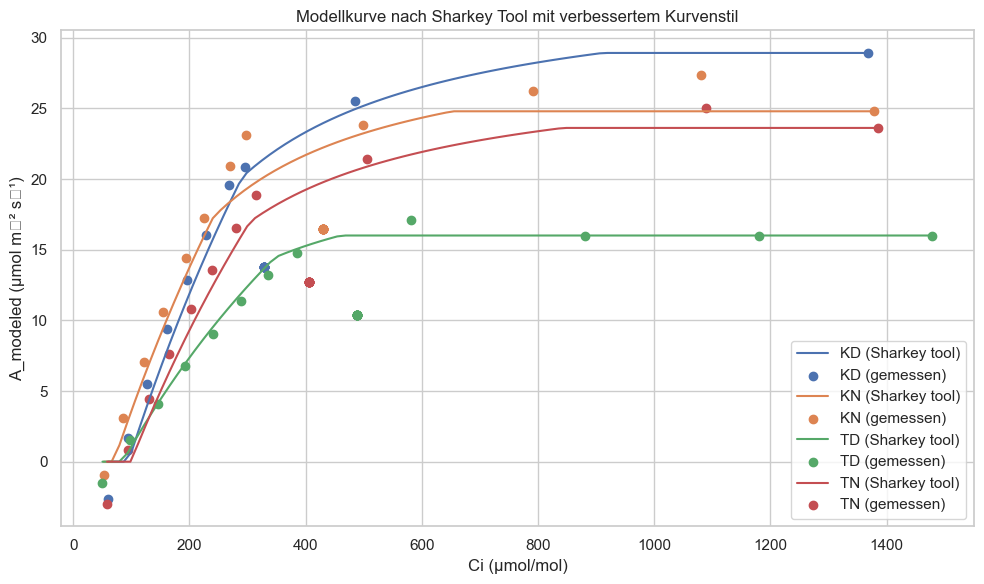

In [ ]:
# fvcb_model-Implementierung (Sharkey Tool)
# Ersetze diese Implementierung durch deine echte Funktion, falls nötig.
def fvcb_model(Ci, Vcmax, J, Rd, TPU, gm, Gamma_star, Kc, Ko, O2):
    Ac = Vcmax * (Ci - Gamma_star) / (Ci + Kc * (1 + O2 / Ko)) - Rd
    Aj = J * (Ci - Gamma_star) / (4 * (Ci + 2 * Gamma_star)) - Rd
    At = 3 * TPU - Rd
    A = np.minimum(np.minimum(Ac, Aj), At)
    return np.maximum(A, 0)

# Setze das seaborn-Theme
sns.set_theme(style="whitegrid")

def insert_rows_and_impute(data, group_col='Plant_ID', insert_factor=2, n_neighbors=2):
    """
    Für jede Gruppe (Plant_ID) werden zusätzliche Zwischenzeilen eingefügt.
    Bei insert_factor=2 wird zwischen zwei Originalzeilen genau eine Zeile eingefügt.
    Anschließend wird der KNNImputer angewendet, um fehlende numerische Werte
    mit dem Mittelwert der zwei nächsten Nachbarn zu füllen.
    """
    groups = []
    
    # Gruppiere nach der gewünschten Spalte
    for plant, group in data.groupby(group_col):
        group = group.copy()
        # Setze den Index zurück, um eine kontinuierliche Sequenz zu erhalten
        group.index = np.arange(len(group))
        
        # Erstelle einen neuen Index, der zwischen den Originalzeilen zusätzliche Positionen enthält
        new_index = np.linspace(group.index.min(), group.index.max(), 
                                num=(len(group)*insert_factor - (insert_factor-1)))
        group_extended = group.reindex(new_index)
        
        # Fülle nicht-numerische Spalten (z.B. Plant_ID) per Vorwärts- und Rückwärtsfüllung auf
        non_numeric_cols = group_extended.select_dtypes(exclude=[np.number]).columns
        group_extended[non_numeric_cols] = group_extended[non_numeric_cols].ffill().bfill()
        
        # Imputation: Wende den KNNImputer mit n_neighbors=2 auf numerische Spalten an
        imputer = KNNImputer(n_neighbors=n_neighbors)
        numeric_cols = group_extended.select_dtypes(include=[np.number]).columns
        group_extended[numeric_cols] = imputer.fit_transform(group_extended[numeric_cols])
        
        groups.append(group_extended)
    
    # Füge alle Gruppen zusammen und setze den Index zurück
    final_df = pd.concat(groups).reset_index(drop=True)
    return final_df

# Annahme: "data" ist dein DataFrame mit den Spalten:
# "Plant_ID", "Ci", "A_measured", "A_modeled", "Vcmax", "J", "Rd", "TPU", "gm"
data_imputed = insert_rows_and_impute(data, group_col="Plant_ID", insert_factor=2, n_neighbors=2)

# Definiere globale Konstanten für das Modell (Passe diese Werte an deine Gegebenheiten an)
Gamma_star = 42.75
Kc = 404.9
Ko = 278400.0
O2 = 210000.0

# Erstelle den Plot: Für jede Plant_ID wird die Modellkurve (vom Sharkey Tool) über den gemessenen Datenpunkten geplottet.
plt.figure(figsize=(10, 6))
plants = data_imputed["Plant_ID"].unique()

for plant in plants:
    plant_data = data_imputed[data_imputed["Plant_ID"] == plant].copy()
    # Sortiere nach Ci, damit die Linie glatt verläuft
    plant_data.sort_values("Ci", inplace=True)
    
    # Erstelle einen feinen Wertebereich für Ci, über den die Modellkurve berechnet wird
    Ci_range = np.linspace(plant_data["Ci"].min(), plant_data["Ci"].max(), 100)
    
    # Parameter aus der Gruppe – hier wird der erste (oder durchschnittliche) Wert genutzt
    Vcmax = plant_data["Vcmax"].iloc[0]
    J = plant_data["J"].iloc[0]
    Rd = plant_data["Rd"].iloc[0]
    TPU = plant_data["TPU"].iloc[0]
    gm = plant_data["gm"].iloc[0]
    
    # Berechne die Modellkurve mit der fvcb_model-Funktion (Sharkey Tool)
    A_curve = fvcb_model(Ci_range, Vcmax, J, Rd, TPU, gm, Gamma_star, Kc, Ko, O2)
    
    # Plot der Sharkey-Tool-Kurve mit verbessertem, geschwungenem Stil
    plt.plot(Ci_range, A_curve, label=f"{plant} (Sharkey tool)", linewidth=1.5, linestyle='-')
    
    # Plot der gemessenen A_modeled-Punkte
    plt.scatter(plant_data["Ci"], plant_data["A_modeled"], label=f"{plant} (gemessen)", marker='o')

plt.xlabel("Ci (µmol/mol)")
plt.ylabel("A_modeled (µmol m⁻² s⁻¹)")
plt.title("Modellkurve nach Sharkey Tool mit verbessertem Kurvenstil")
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/xs/6ky5v5rd4h7g1mmvcjg_4t4h0000gn/T/ipykernel_9568/388414455.py:99: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


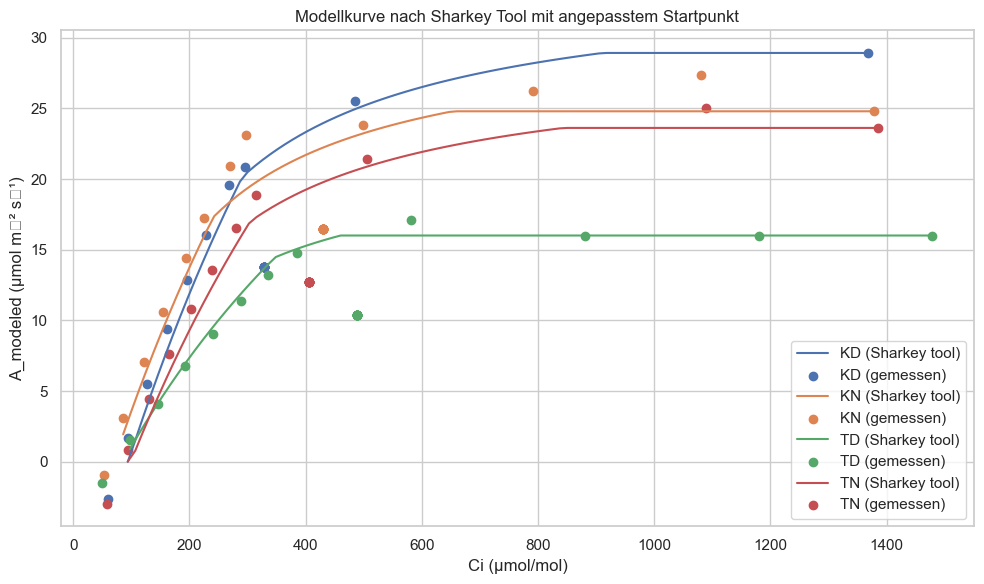

In [30]:
# Beispielhafte fvcb_model-Implementierung (Sharkey Tool)
# Ersetze diese Implementierung durch deine echte Funktion, falls nötig.
def fvcb_model(Ci, Vcmax, J, Rd, TPU, gm, Gamma_star, Kc, Ko, O2):
    Ac = Vcmax * (Ci - Gamma_star) / (Ci + Kc * (1 + O2 / Ko)) - Rd
    Aj = J * (Ci - Gamma_star) / (4 * (Ci + 2 * Gamma_star)) - Rd
    At = 3 * TPU - Rd
    A = np.minimum(np.minimum(Ac, Aj), At)
    return np.maximum(A, 0)

# Setze das seaborn-Theme
sns.set_theme(style="whitegrid")

def insert_rows_and_impute(data, group_col='Plant_ID', insert_factor=2, n_neighbors=2):
    """
    Für jede Gruppe (Plant_ID) werden zusätzliche Zwischenzeilen eingefügt.
    Bei insert_factor=2 wird zwischen zwei Originalzeilen genau eine Zeile eingefügt.
    Anschließend wird der KNNImputer angewendet, um fehlende numerische Werte
    mit dem Mittelwert der zwei nächsten Nachbarn zu füllen.
    """
    groups = []
    
    # Gruppiere nach der gewünschten Spalte
    for plant, group in data.groupby(group_col):
        group = group.copy()
        # Setze den Index zurück, um eine kontinuierliche Sequenz zu erhalten
        group.index = np.arange(len(group))
        
        # Erstelle einen neuen Index, der zwischen den Originalzeilen zusätzliche Positionen enthält
        new_index = np.linspace(group.index.min(), group.index.max(), 
                                num=(len(group)*insert_factor - (insert_factor-1)))
        group_extended = group.reindex(new_index)
        
        # Fülle nicht-numerische Spalten (z.B. Plant_ID) per Vorwärts- und Rückwärtsfüllung auf
        non_numeric_cols = group_extended.select_dtypes(exclude=[np.number]).columns
        group_extended[non_numeric_cols] = group_extended[non_numeric_cols].ffill().bfill()
        
        # Imputation: Wende den KNNImputer mit n_neighbors=2 auf numerische Spalten an
        imputer = KNNImputer(n_neighbors=n_neighbors)
        numeric_cols = group_extended.select_dtypes(include=[np.number]).columns
        group_extended[numeric_cols] = imputer.fit_transform(group_extended[numeric_cols])
        
        groups.append(group_extended)
    
    # Füge alle Gruppen zusammen und setze den Index zurück
    final_df = pd.concat(groups).reset_index(drop=True)
    return final_df

# Annahme: "data" ist dein DataFrame mit den Spalten:
# "Plant_ID", "Ci", "A_measured", "A_modeled", "Vcmax", "J", "Rd", "TPU", "gm"
data_imputed = insert_rows_and_impute(data, group_col="Plant_ID", insert_factor=2, n_neighbors=2)

# Definiere globale Konstanten für das Modell (Passe diese Werte an deine Gegebenheiten an)
Gamma_star = 42.75
Kc = 404.9
Ko = 278400.0
O2 = 210000.0

# Erstelle den Plot: Für jede Plant_ID wird die Modellkurve (vom Sharkey Tool) über den gemessenen Datenpunkten geplottet.
plt.figure(figsize=(10, 6))
plants = data_imputed["Plant_ID"].unique()

for plant in plants:
    plant_data = data_imputed[data_imputed["Plant_ID"] == plant].copy()
    # Sortiere nach Ci, damit die Linie glatt verläuft
    plant_data.sort_values("Ci", inplace=True)
    
    # Bestimme den Ci-Wert, ab dem gemessene A_modeled > 0 sind (falls vorhanden)
    valid_Ci = plant_data.loc[plant_data["A_modeled"] > 0, "Ci"]
    if not valid_Ci.empty:
        Ci_min = valid_Ci.min()
    else:
        Ci_min = plant_data["Ci"].min()
    Ci_max = plant_data["Ci"].max()
    
    # Erstelle einen feinen Wertebereich für Ci, über den die Modellkurve berechnet wird,
    # beginnend ab Ci_min (wo auch Messpunkte vorhanden sind)
    Ci_range = np.linspace(Ci_min, Ci_max, 100)
    
    # Parameter aus der Gruppe – hier wird der erste (oder ein repräsentativer) Wert genutzt
    Vcmax = plant_data["Vcmax"].iloc[0]
    J = plant_data["J"].iloc[0]
    Rd = plant_data["Rd"].iloc[0]
    TPU = plant_data["TPU"].iloc[0]
    gm = plant_data["gm"].iloc[0]
    
    # Berechne die Modellkurve mit der fvcb_model-Funktion (Sharkey Tool)
    A_curve = fvcb_model(Ci_range, Vcmax, J, Rd, TPU, gm, Gamma_star, Kc, Ko, O2)
    
    # Plot der Sharkey-Tool-Kurve
    plt.plot(Ci_range, A_curve, label=f"{plant} (Sharkey tool)", linewidth=1.5, linestyle='-')
    
    # Plot der gemessenen A_modeled-Punkte
    plt.scatter(plant_data["Ci"], plant_data["A_modeled"], label=f"{plant} (gemessen)", marker='o')

plt.xlabel("Ci (µmol/mol)")
plt.ylabel("A_modeled (µmol m⁻² s⁻¹)")
plt.title("Modellkurve nach Sharkey Tool mit angepasstem Startpunkt")
plt.legend()
plt.tight_layout()
plt.show()


In [32]:
data.head(20)

,Plant_ID,Ci,A_measured,A_modeled,Vcmax,J,Rd,TPU,gm
0,KD,60.701570,-3.172402,-2.655739,110.000000,165.500000,7.122449,12.017265,0.839392
1,KD,94.050016,0.664819,1.654876,110.000000,165.500000,7.122449,12.017265,0.839392
2,KD,127.308762,5.022312,5.532979,110.000000,165.500000,7.122449,12.017265,0.839392
3,KD,161.360443,8.076660,9.413076,110.000000,165.500000,7.122449,12.017265,0.839392
4,KD,196.325829,12.810832,12.872343,110.000000,165.500000,7.122449,12.017265,0.839392
5,KD,228.623394,15.376807,16.075729,110.000000,165.500000,7.122449,12.017265,0.839392
6,KD,268.855992,19.837772,19.614541,110.000000,165.500000,7.122449,12.017265,0.839392
7,KD,294.944426,22.037570,20.839150,110.000000,165.500000,7.122449,12.017265,0.839392
8,KD,485.360764,28.201614,25.509018,110.000000,165.500000,7.122449,12.017265,0.839392
9,KD,1368.695686,28.929370,28.929347,110.000000,165.500000,7.122449,12.017265,0.839392


/var/folders/xs/6ky5v5rd4h7g1mmvcjg_4t4h0000gn/T/ipykernel_10746/1907123065.py:63: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()


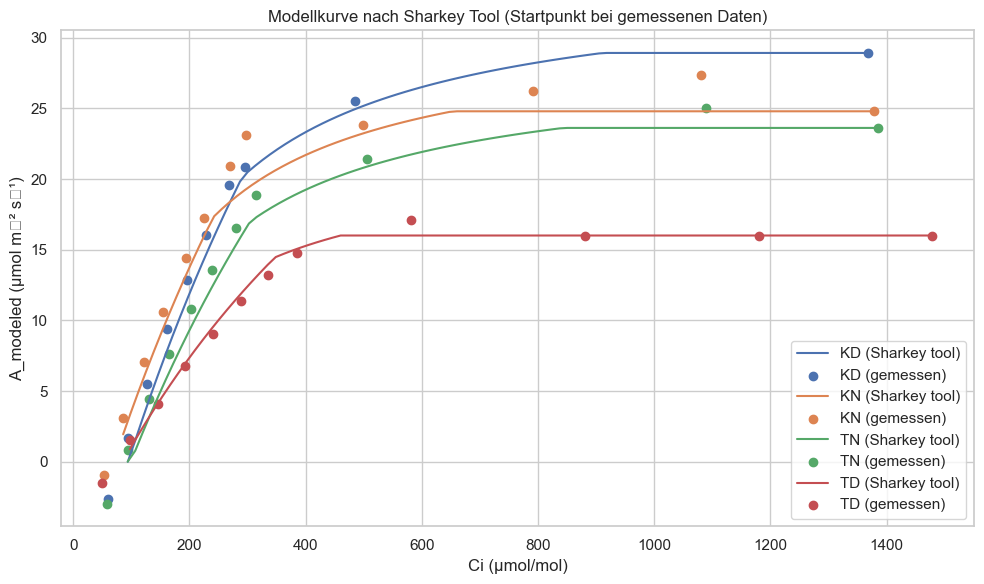

In [15]:
# Beispielhafte fvcb_model-Implementierung (Sharkey Tool)
# Ersetze diese Funktion durch deine echte Implementierung, falls nötig.
def fvcb_model(Ci, Vcmax, J, Rd, TPU, gm, Gamma_star, Kc, Ko, O2):
    Ac = Vcmax * (Ci - Gamma_star) / (Ci + Kc * (1 + O2 / Ko)) - Rd
    Aj = J * (Ci - Gamma_star) / (4 * (Ci + 2 * Gamma_star)) - Rd
    At = 3 * TPU - Rd
    A = np.minimum(np.minimum(Ac, Aj), At)
    return np.maximum(A, 0)

# Setze das seaborn-Theme
sns.set_theme(style="whitegrid")

# Annahme: "data" ist dein DataFrame mit den Spalten:
# "Plant_ID", "Ci", "A_measured", "A_modeled", "Vcmax", "J", "Rd", "TPU", "gm"
# Es wird ausschließlich mit den Originaldaten gearbeitet.

# Definiere globale Konstanten für das Modell (bitte an deine Gegebenheiten anpassen)
Gamma_star = 42.75
Kc = 404.9
Ko = 278400.0
O2 = 210000.0

plt.figure(figsize=(10, 6))
plants = data["Plant_ID"].unique()

for plant in plants:
    # Verwende nur die originalen Daten für die jeweilige Plant_ID
    plant_data = data[data["Plant_ID"] == plant].copy()
    # Sortiere die Daten nach Ci, um einen glatten Verlauf zu ermöglichen
    plant_data.sort_values("Ci", inplace=True)
    
    # Bestimme den Ci-Wert, ab dem gemessene A_modeled > 0 vorliegen (falls vorhanden)
    valid_Ci = plant_data.loc[plant_data["A_modeled"] > 0, "Ci"]
    if not valid_Ci.empty:
        Ci_min = valid_Ci.min()
    else:
        Ci_min = plant_data["Ci"].min()
    Ci_max = plant_data["Ci"].max()
    
    # Erstelle einen feinen Ci-Bereich, der von Ci_min bis Ci_max reicht
    Ci_range = np.linspace(Ci_min, Ci_max, 100)
    
    # Verwende Parameter aus den Daten (hier: erster Wert; alternativ kann auch ein Durchschnitt genommen werden)
    Vcmax = plant_data["Vcmax"].iloc[0]
    J = plant_data["J"].iloc[0]
    Rd = plant_data["Rd"].iloc[0]
    TPU = plant_data["TPU"].iloc[0]
    gm = plant_data["gm"].iloc[0]
    
    # Berechne die Modellkurve mittels fvcb_model
    A_curve = fvcb_model(Ci_range, Vcmax, J, Rd, TPU, gm, Gamma_star, Kc, Ko, O2)
    
    # Plot der Sharkey-Tool-Kurve
    plt.plot(Ci_range, A_curve, label=f"{plant} (Sharkey tool)", linewidth=1.5, linestyle='-')
    
    # Plot der gemessenen A_modeled-Punkte
    plt.scatter(plant_data["Ci"], plant_data["A_modeled"], label=f"{plant} (gemessen)", marker='o')

plt.xlabel("Ci (µmol/mol)")
plt.ylabel("A_modeled (µmol m⁻² s⁻¹)")
plt.title("Modellkurve nach Sharkey Tool (Startpunkt bei gemessenen Daten)")
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/xs/6ky5v5rd4h7g1mmvcjg_4t4h0000gn/T/ipykernel_10746/2489599758.py:67: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


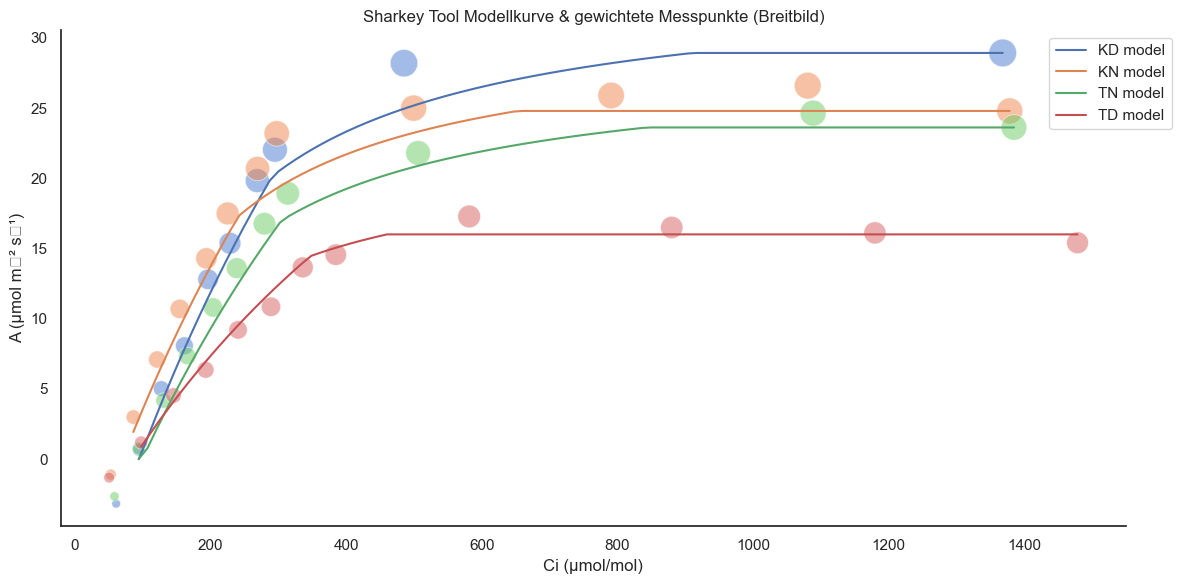

In [13]:
# Beispielhafte fvcb_model-Implementierung (Sharkey Tool)
def fvcb_model(Ci, Vcmax, J, Rd, TPU, gm, Gamma_star, Kc, Ko, O2):
    Ac = Vcmax * (Ci - Gamma_star) / (Ci + Kc * (1 + O2 / Ko)) - Rd
    Aj = J * (Ci - Gamma_star) / (4 * (Ci + 2 * Gamma_star)) - Rd
    At = 3 * TPU - Rd
    A = np.minimum(np.minimum(Ac, Aj), At)
    return np.maximum(A, 0)

# Setze das seaborn-Theme
sns.set_theme(style="white")

# Globale Konstanten für das Modell
Gamma_star = 42.75
Kc = 404.9
Ko = 278400.0
O2 = 210000.0

# Annahme: "data" ist dein DataFrame mit den Spalten:
# "Plant_ID", "Ci", "A_measured", "A_modeled", "Vcmax", "J", "Rd", "TPU", "gm"

# Erstelle einen Relplot, der die echten Messpunkte als Bubble-Plot darstellt,
# mit einem breitbildigen Layout (aspect=2)
g = sns.relplot(
    x="Ci", y="A_measured",
    hue="Plant_ID", size="A_measured",
    sizes=(40, 400), alpha=0.5, palette="muted",
    height=6, aspect=2, data=data, legend=False

)
ax = g.ax

# Für jede Plant_ID: Berechne und überlagere die Modellkurve, die ab dem ersten gültigen Messpunkt startet.
plants = data["Plant_ID"].unique()
for plant in plants:
    plant_data = data[data["Plant_ID"] == plant].copy()
    plant_data.sort_values("Ci", inplace=True)
    
    # Bestimme den niedrigsten Ci-Wert, bei dem A_measured > 0 ist
    valid = plant_data[plant_data["A_measured"] > 0]
    if not valid.empty:
        Ci_min = valid["Ci"].min()
    else:
        Ci_min = plant_data["Ci"].min()
    Ci_max = plant_data["Ci"].max()
    
    # Erstelle einen feinen Ci-Bereich von Ci_min bis Ci_max
    Ci_range = np.linspace(Ci_min, Ci_max, 100)
    
    # Parameter aus den Daten (hier wird der erste Wert der Gruppe genutzt)
    Vcmax = plant_data["Vcmax"].iloc[0]
    J = plant_data["J"].iloc[0]
    Rd = plant_data["Rd"].iloc[0]
    TPU = plant_data["TPU"].iloc[0]
    gm = plant_data["gm"].iloc[0]
    
    # Berechne die Modellkurve mit fvcb_model
    A_curve = fvcb_model(Ci_range, Vcmax, J, Rd, TPU, gm, Gamma_star, Kc, Ko, O2)
    
    # Plot der Modellkurve auf derselben Achse
    ax.plot(Ci_range, A_curve, label=f"{plant} model", lw=1.5)

# Passe Achsenbeschriftungen und Titel an
ax.set_xlabel("Ci (µmol/mol)")
ax.set_ylabel("A (µmol m⁻² s⁻¹)")
ax.set_title("Sharkey Tool Modellkurve & gewichtete Messpunkte (Breitbild)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
plt.tight_layout()
plt.show()
